In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import islice
import arabicstopwords.arabicstopwords as stp

import pickle as pkl

import sentencepiece as sp

import tkseem as tk
import gensim

In [2]:
df = pd.read_csv('all_poems_bert_processed.csv')
df.head()

,poem_text,bert_t
0,خليلي لا تستعجلا أن تزودا وأن تجمعا شملي وت...,"['خليل', 'لا', 'تستعجل', 'أن', 'تزود', 'أن', '..."
1,فما لبث يوما بسابق مغنم ولا سرعتي يوما بساب...,"['ما', 'لبث', 'يوم', 'سابق', 'مغنم', 'لا', 'سر..."
2,وإن تنظراني اليوم أقض لبانة وتستوجبا منا عل...,"['إن', 'تنظراني', 'يوم', 'أقض', 'بان', 'تستوجب..."
3,لعمرك ما نفس بجد رشيدة تؤامرني سرا لأصرم مرثدا,"['عمر', 'ما', 'نفس', 'جد', 'رشيد', 'تؤامرني', ..."
4,وإن ظهرت منه قوارص جمة وأفرع في لومي مرارا ...,"['إن', 'ظهر', 'من', 'قوارص', 'جم', 'أفرع', 'في..."


In [3]:
from arabert.preprocess import ArabertPreprocessor

model_name="bert-base-arabert"
arabert_prep = ArabertPreprocessor(model_name=model_name)

text = "ولن نبالغ إذا قلنا إن هاتف أو كمبيوتر المكتب في زمننا هذا ضروري"
arabert_prep.preprocess(text)

[2024-06-08 23:37:47,035 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


'و+ لن نبالغ إذا قل +نا إن هاتف أو كمبيوتر ال+ مكتب في زمن +نا هذا ضروري'

## Doc2Vec

In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
taggedData = [TaggedDocument(words=doc, tags=[str(i)]) for doc, i in zip(df['bert_t'], df.index)]

In [15]:
model = Doc2Vec(dm=1, vector_size=1024, min_count=3, epochs=35, workers=-1, window=6, dm_concat=1)
model = Doc2Vec(dm=0, vector_size=160, min_count=3, epochs=20, workers=-1, window=5)
model

In [16]:
model.build_vocab(taggedData)

In [17]:
model.train(taggedData,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [8]:
model.save('models/doc2vec.model')

In [4]:
model = gensim.models.Doc2Vec.load('models/doc2vec.model')

In [5]:
prompt = 'وددت رؤية الياسمين'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
clean_prompt

['ودد', 'رؤي', 'ياسمين']

In [6]:
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=500)
sims

[('271092', 0.16008226573467255),
 ('1517806', 0.1452469378709793),
 ('324089', 0.1450026035308838),
 ('1035005', 0.1427231878042221),
 ('76527', 0.13988465070724487),
 ('932733', 0.13808618485927582),
 ('1128373', 0.13752567768096924),
 ('813510', 0.13569432497024536),
 ('464554', 0.1352037936449051),
 ('1315966', 0.13504187762737274),
 ('1346107', 0.13467054069042206),
 ('1218789', 0.13412228226661682),
 ('495768', 0.1339070200920105),
 ('1214026', 0.1338507980108261),
 ('1357255', 0.1338154822587967),
 ('277008', 0.13343125581741333),
 ('121446', 0.13342969119548798),
 ('1457029', 0.13136592507362366),
 ('388475', 0.1307094395160675),
 ('143920', 0.13044124841690063),
 ('659640', 0.1303095817565918),
 ('4581', 0.13012225925922394),
 ('1573306', 0.13004279136657715),
 ('1598741', 0.12988393008708954),
 ('1019111', 0.12918564677238464),
 ('1464351', 0.12916167080402374),
 ('354586', 0.12909434735774994),
 ('510193', 0.12851795554161072),
 ('1683913', 0.12818680703639984),
 ('1684615',

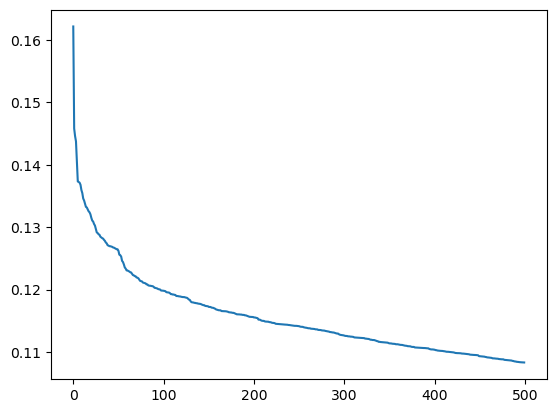

In [11]:
array = np.array(sims)
df_ggl = pd.DataFrame(array, columns=['id', 'similarity'])
plt.plot(df_ggl.index, df_ggl['similarity'].astype(float))

In [12]:
df.loc[int(sims[0][0])]

poem_text     وصحب إن غروا بملام مثلي    فرب أصاحب بالإثم باؤا
bert_t       ['صحب', 'إن', 'غرو', 'ملام', 'مثل', 'رب', 'أصا...
Name: 449264, dtype: object

In [7]:
prompt = 'ليت الشباب يعود'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=3)
print(df.loc[int(sims[0][0]), 'poem_text'])
print(df.loc[int(sims[1][0]), 'poem_text'])
print(df.loc[int(sims[2][0]), 'poem_text'])

فوق ابنك الموموق منك ولا تكن    بعشرته سمحا فيهلكه السمح
لا تحرم الشفاعة    يا معدن النفاعه
فبباب فضلك قد وقفت ولم أزل    بعظيم قدرك في الورى أتضرع


In [10]:
prompts = [
    'الحماسة والفخر',
    'روعة البحر',
    'الأمل والتفاؤل',
    'معاني الحياة والموت',
    'وجدانية الحب العذري',
    'التأمل في مصائر الإنسان',
    'حياة العرب قبل الإسلام',
    'العدمية والبحث عن الذات',
    'الفضيلة والأخلاق',
    'السلام والتسامح',
    'العدالة والمساواة',
    'كيف تخاف الفقر والله رازقا',
    'التشرد والهجرة والبحث عن الوطن',
    'عيناك نازلتاالقلوب',
    ' كتب الدمع بخدي عهده',
    'لا يحمل الحقد من تعلو به الرتب',
    'أتعرف رسم الدار',
    'الأصدقاء مثل النجوم',
    ' أحلك الأوقات',
    'شعر بدوي',
    ' الثقة بالله',
    ' ذكريات الطفولة',
    'المرء يأمل أن يعيش',
    'الوطن والانتماء',
    ' الحرية والنضال',
    'قم للمعلم وفه التبجيلا',
    'وعذرتهم وعرفت ذنبي',
    'إليك يا أمي',
    'فأصبح بعد الحرب',
    'إذا حكم القضاء',
    'ليت الأحزان',
    'فرحي مثل طائر',
    'نار الغضب',
    'صوت المطر ينعش روحي',
    'تنير ليالي',
    'إِن الثعالب بالضحى',
    'صبور على مر الحوادث',
    'البحث عن الحقيقة رحلة لا نهاية لها',
    'مرآة الروح',
    'كلما نسينا دروس الماضي',
    'دع الأيام تفعل ما تشاء',
    'وقفت على الديار',
    'رمال الصحراء',
    'شموخ',
    'تفاؤل',
    'نصر',
    'حمامة',
    'ساذج'
]

f = open("output_doc2vec.txt", 'w')

for prompt in prompts:
    f.write(prompt + "\n")
    
    clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
    inferred_vector = model.infer_vector(clean_prompt)
    sims = model.dv.most_similar([inferred_vector], topn=3)
    f.write(df.loc[int(sims[0][0]), 'poem_text'] + "\n")
    f.write(df.loc[int(sims[1][0]), 'poem_text'] + "\n")
    f.write(df.loc[int(sims[2][0]), 'poem_text'] + "\n")
    
    f.write("\n")
f.close()

In [22]:
prompt = 'ثلوج الجبال'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=3)
print(df.loc[int(sims[0][0]), 'poem_text'])
print(df.loc[int(sims[1][0]), 'poem_text'])
print(df.loc[int(sims[2][0]), 'poem_text'])

وقس على النحل خلال الشهد    
فلم يزل مجالدا مقارعا    منكبا درء الأعادي قارعا
في جوار لا يضام به    هذه الدنيا ويوم غده


In [20]:
prompt = 'المنية مفاجئة'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=3)
print(df.loc[int(sims[0][0]), 'poem_text'])
print(df.loc[int(sims[1][0]), 'poem_text'])
print(df.loc[int(sims[2][0]), 'poem_text'])

كم جلوت الشكوك تعرض في نص    وصى وكم نصرت إماما
كلما أملت يوما صالحا    عرض المكروه لي في أملي
تنهض خصرا لم يزل    من ردفها في ملل


In [21]:
prompt = 'الحب'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=3)
print(df.loc[int(sims[0][0]), 'poem_text'])
print(df.loc[int(sims[1][0]), 'poem_text'])
print(df.loc[int(sims[2][0]), 'poem_text'])

لا تكن مثل سراب    ريء لم يشف غليلا
وسلاح الخصم مشحوذ متين    
أما لك لا ترثي لحاله مكمد    فينسخ هجر اليوم وصلك في غد


In [11]:
prompt = 'المنية مفاجئة'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=500)
df.loc[int(sims[0][0])]

poem_text                 وليس كذا فلا تعذل    خليلك عذل منكمش
bert_t       ['ليس', 'كذا', 'لا', 'تعذل', 'خليل', 'عذل', 'م...
Name: 776775, dtype: object

In [12]:
prompt = 'الحب'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=500)
df.loc[int(sims[0][0])]

poem_text    كتب العشق بأني بهوى العاشق اعلم    فإليه نتراج...
bert_t       ['كتب', 'عشق', 'أن', 'هوى', 'عاشق', 'اعلم', 'إ...
Name: 1559085, dtype: object

In [15]:
prompt = 'الثلج يتساقط'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=500)
df.loc[int(sims[0][0])]

poem_text          فانبرى يلقى ذيوميذ الخطاب    
bert_t       ['انبرى', 'يلقى', 'ذيوميذ', 'خطاب']
Name: 1404366, dtype: object

In [16]:
prompt = 'مدينة جميلة'

clean_prompt = [token for token in arabert_prep.preprocess(prompt).split() if '+' not in token]
inferred_vector = model.infer_vector(clean_prompt)
sims = model.dv.most_similar([inferred_vector], topn=500)
df.loc[int(sims[0][0])]

poem_text           ولى وللأرض على أنها    لم يحتملها قط مقدار
bert_t       ['ولى', 'أرض', 'على', 'أن', 'لم', 'يحتمل', 'قط...
Name: 1156146, dtype: object